# Processing Sequences using RNNs and CNNs

Recurrent Neural Networks (RNNs) can work with sequences with arbitrary lengths, rather than fixed input shape neural networks. These arbitrary sequences can be sentences, documents or audio samples, RNNs aid with Natural Language processing tasks such as transalation and speech-to-text.

RNNs can handle sequential data (i.e. time series) although, small sequences can be handled by regular dense networks too while CNNs can handle longer sequences too. 

## Recurrent Neurons and Layers

So far we have only seen feedforward neural networks. RNNs produces an output that sends it back to itself as an input. At each time step, $t$, the neurons receives an input $x_{(t)}$ and its own output $y_{(t-1)}$. 

RNNs have weights, $W_x$ and $W_y$ for the input $x_{(t)}$ and weights for its output of the previous time step $y_{(t-1)}$. 

Therefore the output of a RNN would be:
$y_{(t)} = \phi(W_x^Tx_{(t)} + W_y^Ty_{(t-1)} + b$)
where $\phi$ is the activation function - either tanh or ReLU should work ok - and at $t=0$ outputs are considered to be zero.

#### Memory Cell

A recurrent neuron is capable of preserving state across time steps ~ around 10 steps long ~ this is called memory cell. It is capable of learning basic patterns which more complex architectures can learn a lot longer patterns, x10 more.

#### Input and Output Sequences
RNNs are able to produce many number of outputs depending on the functionality required. There are several types of networks:

- **Sequence to Sequence**: 
This is where the network is given a sequence and outputs a sequence. This is useful for predicting stock prices (i.e. time series data).

- **Sequences to Vector**: Feed the network a sequence and return a single vector an output. For example, given a movie review input we can output a sentiment score.

- **Vector to Sequence**: Feed the network an input vector over and over again at each time step and outputs a sequence. This can be usful for predicting a caption for an image/output of a CNN. 

- **Encoder Decoder**: This is essentially a Sequence to Vector (Encoder) followed by Vector to Sequence (Decoder) network. This sort of network can be used to translate multiple inputs to a vector representation and then decode to another sequence. For example, translating from one language to another. We have to read the entire sentence to enable a proper translation of the sentence.


## Training RNNs - backpropagation through time (BPTT)

To train a RNN, we unroll it through time. This strategy is called backpropagation through time. 

We first pass through the network then calculate the cost function, where only the relevant outputs are used during the backward pass. Fortunately, `keras` takes care of this for us.

## Forecasting a Time Series

There are two types of time series data: 

1. Univariate time series: a single value per time step. For example, number of active users on a website.
2. Multivariate time series: multiple values per time step. For example, financial data that contain the company's revenue, debt etc.).

With time series data we typically like to carry out a task called **forecasting**, predicting future values, or **postdict**, imputing missing values. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [2]:
def generate_time_series(batch_size, n_steps):
  """
  Function for creating time series data
  """
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # returns array of shape(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)


Create time series data: train, valid, test datasets

In each numpy array we have `batch_size` number of time series each containing a time step of `n_steps`.

Note: the X dataset contains all the values including, what we we would define as the "label". The y dataset contains all the values at the n_steps (i.e. the last step), this is the value that we are trying to predicting using all available data.

In [3]:
np.random.seed(24)

n_steps = 50
series = generate_time_series(10000, n_steps + 1) # note: plus 1 as this is the time step values we are predicting
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # upto but not including 7,000th row
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] #  inclusive 7,000 to 8,999
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] #  inclusive 9,000 to end

Below, we are plotting just 1 time series instance within the dataset. 

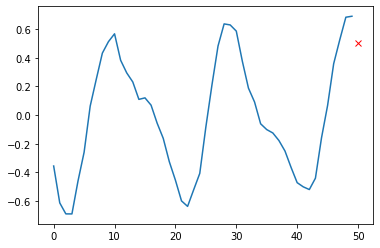

In [4]:
plt.plot(X_valid[0, :, 0])
plt.plot(50, y_valid[0], 'rx')

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
  """
  Create a function to plot time series data
  """
  plt.plot(series, ".-")
  if y is not None:
      plt.plot(n_steps, y, "bx", markersize=10)
  if y_pred is not None:
      plt.plot(n_steps, y_pred, "ro")
  plt.grid(True)
  if x_label:
      plt.xlabel(x_label, fontsize=16)
  if y_label:
      plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

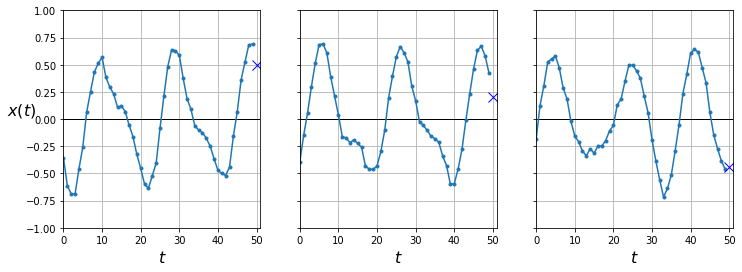

In [6]:
# visualize time series data
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

When dealing with time series the data shape tends to be:
```
(batch_size, time-step, dimensionality)
```
**dimensionality is 1 for univariate and >1 multi-variate time series.**


In [7]:
X_train.shape

(7000, 50, 1)

In [8]:
# naive approach
# use the last observed value as the prediction for t+1
y_pred = X_valid[:, -1]
np.mean(keras.metrics.mean_squared_error(y_pred=y_pred, y_true=y_valid))

0.020327685

This mean squared error is not that bad. 

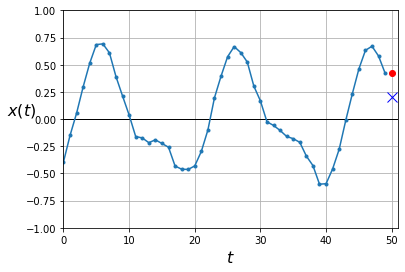

In [9]:
# plot 1 of the time series
plot_series(X_valid[1, :, 0], y_valid[1, 0], y_pred[1, 0])

#### Linear Regression

In [10]:
# create model
model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[50, 1]),
                                 keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1335 - val_loss: 0.0593
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.0279
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0205 - val_loss: 0.0170
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0068

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 773us/step - loss: 0.0042


0.0042021796107292175

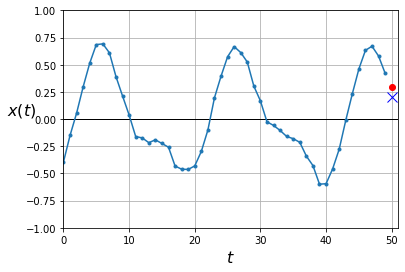

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, 0], y_valid[1, 0], y_pred[1, 0])

The naive approach worked fairly well and this, alongisde the linear model, can form a great baseline metric to assess more complex models against.

#### Simple RNNs

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1]) # contains only 1 neuron
])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0955 - val_loss: 0.0477
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0362 - val_loss: 0.0292
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0247 - val_loss: 0.0215
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0193 - val_loss: 0.0174
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0112 - val_loss: 0.0111

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0110


0.010972266085445881

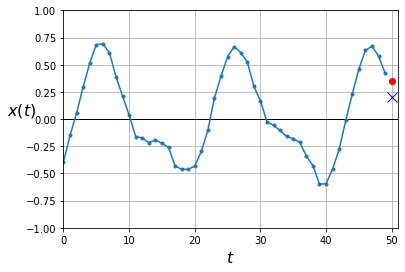

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, 0], y_valid[1, 0], y_pred[1, 0]) # plot value for 1st time series

In [16]:
X_valid[0,:,0].shape

(50,)

## Other models, Trends and Seasonality 

1. Weighted moving averages
2. Autoregressive integrated Moving Average (ARIMA)

Both of these models require that you remove the trend and seasonality. For example, if a product sales increases every month then you would remove this trend. Similiarly, if sales tend to increase during summer then you would remove this by computing the difference from the year before - called *differencing*. 

Once the model is trained you would add the trends and seasonality back into the predictions to obtain final predictions. 

For RNNs, it may not be neccessary to compute this but it may improve performance, as trends and seasonality does not need to be learned.


## Deep RNNs

As we saw earlier, a single layer RNN with a single neuron unit did not do much better when compared against the linear model. Lets try a deep RNNs. 

Remeber to specify `return_sequences = True`, as this will tell the RNN layer to output a 3D array (containing outputs from all time steps). Otherwise, the output will be a 2D vector (containing an output from just the last time step).

In [17]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1) # this is not ideal!
])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 27ms/step - loss: 0.0268 - val_loss: 0.0095
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 5/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 7/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0035 - val_lo

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0032


0.0032039079815149307

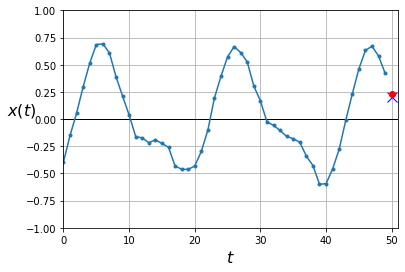

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, 0], y_valid[1, 0], y_pred[1, 0])

This beats the linear model by a good margin. 

However, we should understand that the last layer can be improved if we use a `Dense` layer instead. This is because the 1 recurrent neuron is not that useful and will probably only use information from previous layers. Also we cannot use other activation functions. 

In [20]:
# using a dense layer
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1) # we are only changing the last layer
])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.0116 - val_loss: 0.0037
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0031 - val_lo

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0032


0.003238341072574258

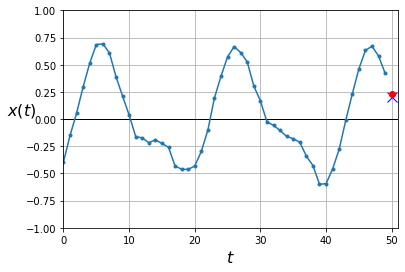

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[1, :, 0], y_valid[1, 0], y_pred[1, 0])

This model was marginally better than, both, the SimpleRNN and linear models. 

### Predicting 10 time steps ahead

As you can see predicting a single value 1 time step ahead is relatively easy to do. What if we wanted to predict several time steps ahead?

One way could be to predict the next value and then add that value back into the 'training' set so you can then predict the next value after that. This is not the best method since errors can accumulate, typically growing larger after the first time step prediction. 

#### Individual predictions 

In [23]:
# generate fake data that add the prediction onto the 
np.random.seed(4)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

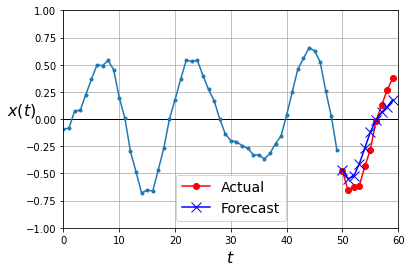

In [24]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

#### Multiple predictions

There are quite a few ways to approach predicting the next $x$ number of  this:

1. Predict the next $x$ steps by changing the target value to include those steps and forecasting the next 10 steps based on the very last step only. For example, if we wanted to predict the next 10 values then we would insert the next 10 values into the target and changing the model output to have 10 outputs instead of 1. 

Making the model a **Sequence to Vector** model. 

2. Another way is training the model is to predict the next steps 10 at each and every time step. For example, train the model on 0 to 9, then predict 1 to 10. Then train again for 1 to 10 and predict 2 to 11 etc. This will allow more gradients flowing through the model because a loss will calculated at every time step. Using this approach will stablise and speed up training. 

Making the model a **Sequence to Sequence** model. Each input sequence is the same length as the target sequence.

Note. The model is NOT cheating (i.e. data leakage), even though it learns using the data from the targets its trying to predict. The model is considered a **Casual model** and it only knows the targets for the past time steps and cannot look ahead!



In [25]:
# generate time series where the target contains the next 10 values

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [26]:
Y_train[0, 0] # shape (10,), which are the 10 steps ahead

array([ 0.33874455,  0.18980233,  0.00611999, -0.19590542, -0.38614848,
       -0.54409838, -0.62904716, -0.66339582, -0.65724516, -0.51447874])

In [27]:
# Use TimeDistributed - applies Dense layer at every time step
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # change to True to make into a s-to-s model
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # we are only changing the units on last layer
])

# we only care about the last value's mse not the rest
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0534 - last_time_step_mse: 0.0419 - val_loss: 0.0438 - val_last_time_step_mse: 0.0311
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0432 - last_time_step_mse: 0.0311 - val_loss: 0.0409 - val_last_time_step_mse: 0.0290
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0375 - last_time_step_mse: 0.0244 - val_loss: 0.0351 - val_last_time_step_mse: 0.0212
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0335 - last_time_step_mse: 0.0207 - val_loss: 0.0302 - val_last_time_step_mse: 0.0173
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0298 - last_time_step_mse: 0.0169 - val_loss: 0.0293 - val_last_time_step_mse: 0.0167
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0286 - last_time_step_mse: 0.0158 - val_loss: 0.0274 - val_last_time_step_mse: 0.0148
Epoch 7/20
219/219 [==

In [28]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0179 - last_time_step_mse: 0.0054


[0.017897022888064384, 0.005372166633605957]

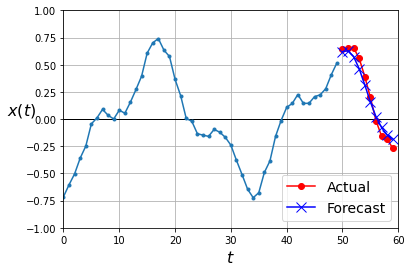

In [29]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

The Sequence to Sequence model is much better when compared to the Sequence to Vector model. 

This approach will work okay for short sequences but handling long sequences can be a challenge because of Short Term memory or Unstable gradient problems observed with RNNs.

## Handling Long Sequences

Unlike the short sequences we have seen, above, long sequences over many time steps makes unrolled RNNs a very deep network. As with other deep networks, it will suffer from unstable gradients - vanishing gradients. Furthermore, it will forget the first inputs in the sequence. 

### Unstable Gradient Problem
The problem of gradients growing larger and larger or vanishing completely is observed with other deep neural networks. Therefore, common solutions are: good parameter initialization, dropout, faster optimization and so on. 

But wait! Non-saturating activation functions won't help us! This is because during gradient descent weights are updated after every time step, which will gradually increase. To clarify the difference between the saturated and nonsaturated:

- **Non-saturating activation functions:** Where $\lim_{z \rightarrow \infty} f(z) = + \infty$, as $z$ increases $f(z)$ increases towards infinity. For example, ReLU and its variants.
- **Saturating activation functions:** have a limit, such as sigmoid $[0, 1]$ or tanh $[-1, +1]$. 

The unstable gradient problems tend to be even worse when activation functions are non-saturated such as ReLU - which is why tanh is the default in `keras`.

<br> 
#### What about what `Batch Normalization`?

`BatchNormalization` work well with feedforward networks but not as efficiently for RNNs - however, it will improve the model but not by much. This is because BN's cannot be used between time steps and only between RNN layers. Researchers also found that applying BN between neurons (with the same same parameters) did not yield better results.

### Layer Normalization

Another approach is required. Layer normalization is applied across features dimensions. It has the advantage of calculating the required statistics on the fly at each time step. Making it behave the same way during training and testing. 




In [30]:
# create RNN class that has LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
  """
  Simple RNN cell with layer normalization.
  """
  def __init__(self, units, activation='tanh', **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = keras.layers.LayerNormalization()
    self.activation = keras.activations.get(activation)
  
  def call(self, inputs, states):
    outputs, _ = self.simple_rnn_cell(inputs, states) # RNN cells return 2 values
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]


In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 41ms/step - loss: 0.1561 - last_time_step_mse: 0.1497 - val_loss: 0.0714 - val_last_time_step_mse: 0.0572
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0627 - last_time_step_mse: 0.0497 - val_loss: 0.0562 - val_last_time_step_mse: 0.0426
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0540 - last_time_step_mse: 0.0396 - val_loss: 0.0498 - val_last_time_step_mse: 0.0354
Epoch 4/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0481 - last_time_step_mse: 0.0330 - val_loss: 0.0449 - val_last_time_step_mse: 0.0298
Epoch 5/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0445 - last_time_step_mse: 0.0300 - val_loss: 0.0418 - val_last_time_step_mse: 0.0270
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0408 - last_time_step_mse: 0.0262 - val_loss: 0.0385 - val_last_time_step_mse: 0.0233
Epoch 7/20
219/219 [=

By using Layer Normalization and a dropout rate for the hidden states we can handle unstable gradients. 

### Short Term Memory Problem 

As the data progresses through a RNN network, information is lost at every time step. At the end, the network contains no traces of the very first input. For example, imagine a sentence and not being able to recall how it started, this will make the sentence translation very difficult.

The solution is Long Short-Term Memory (LTSM) cells. They have proven so successful that they are used instead of the basic cells.

### Long Short Term Memory (LSTM)

The LSTM cell converges faster and detects long term dependencies in the data. To add this into your network you can use `keras.layers.LSTM` or pass it as an argument into `keras.layers.RNN`*. The benefit of the `LSTM` layer is the additional GPU support. 

**typically, you would do this to customise the simple RNN layer.*  

The **output** of the LSTM are 2 vectors: $h_{(t)}$ and $c_{(t)}$ - which can be thought of a the short and long term states respectively.

The architecture of LSTM is complex, it consists of fully connected layers, logistc and tanh activation functions, multiple gates (i.e. forget, input and output) and gate controllers. The network looks similiar to a transistor! It stores information in the long term, decides what to throw away and what to read from it.

The output from the fully connected layers are passed to the gates which either removes or adds to the long term state or, more granularly, at each time step both to $h_{(t)}$ and $y_{(t)}$. 

The responsibility of each gate varies:

- **forget gate**: performs element wise multiplication and removes parts of the long term states. It preserves information for as long as it is needed.
- **input gate**: performs element wise multiplication and then adds this to the long term memory state. It recognises which inputs are important and inputs into longer term. 
- **output gate**: controls which parts of the long term states needs to be passed into short term state $h_{(t)}$ and the output $y_{(t)}$. It extracts information from the long term state when it is needed.

Concretely, to put this into multiple formulas: 

$i_{(t)} = \sigma(W_{xi}^T X_{t} + W_{hi}^T h_{(t-1)} + b_i)$

$f_{(t)} = \sigma(W_{xf}^T X_{t} + W_{hf}^T h_{(t-1)} + b_f)$

$o_{(t)} = \sigma(W_{xo}^T X_{t} + W_{ho}^T h_{(t-1)} + b_o)$

$g_{(t)} = \tanh (W_{xg}^T X_{t} + W_{hg}^T h_{(t-1)} + b_i)$

Using the output from the formulae above, we can find the states - $c$ and $h$, as well as the output $y$.

$c_{(t)} = f_{(t)} \otimes c_{(t-1)} + i_{(t)} \otimes g_{(t)}$

$h_{(t)} = o_{(t)} \otimes \tanh (c_{(t)})$

$W$ are the weight matrices for each of the (4) fully connected layers, $b$ are the biases that are all initialised to 1 which prevents forgetting everything at the beginning of training. 

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 42ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [33]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.008560794405639172]

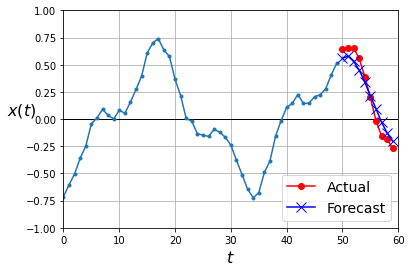

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## LSTM Variants 
 A paper in 2015, showed that all LSTM variants performed roughly the same but this is still worth exploring. https://arxiv.org/abs/1503.04069

 The paper showed that the activation functions contributed the most towards improving model performance.

### Peephole Connection

This is a small variation to the regular LSTM cell, where a 'peephole' connection is added. The previous long term state, $c_{(t-1)}$, is added as an input to the forget and input gates. While the current long term state, $c_{(t)}$ is added as input to the controller of the output gate.

The may improve the performance but it is not a gaurentee. A popular variant to LSTM cell is GRU cells.





## GRU Cells

The Gated Recurrent Unit (GRU) cell is growing in popularity because it simiplifies the LSTM architecture. 

The state vectors $h$ and $c$ are merged into a single vector $h$. The single gate controller $z$ controls becomes both the forget and input gates. It erases the memory before it stores it in that location. 

The output is the full state vector at every time step, and because of this there is a new gate controller, $r$ that controls which part to show to the main layer $(g_{(t)})$. 

Concretely, to put this into multiple formulas: 

$z_{(t)} = \sigma(W_{xy}^T X_{t} + W_{hz}^T h_{(t-1)} + b_z)$ -> controls the forget and input gates.


$r_{(t)} = \sigma(W_{xt}^T X_{t} + W_{hr}^T h_{(t-1)} + b_r)$ -> controls which part to show mian layer, $g$.


$g_{(t)} = \tanh(W_{xg}^T X_{t} + W_{xg}^T (r_{(t)} \otimes h_{(t-1)}) + b_g)$ -> main layer gate.

From the above, we can gain the output of the cell:
$h_{(t)} = z_{(t)} \otimes h_{(t-1)} + (1 - z_{(t)}) \otimes g_{(t)}$

Looking at the equation above, we can see that previous hidden state and the main layer gate contributes towards the final output. However, the struggle to learn long term patterns when sequences are 100 time steps or more. To solve this we can shorten the input sequences by using 1D convolutional layers.


#### Process Sequences using 1D Convolutional Layers

As with CNNs, we saw that filter maps are produced which extract useful features within the data. Similiarly, a `1D convolutional` layer which outputs short sequence patterns, no larger than the kernel size. Using a 1D convolutional layer offers no memory since it does not hold any states between time steps. 

The 1D layer effectively downsamples (reduces temporal resolution) and, therefore, allows the RNN to detect long term solutions and alleviates unstable gradients. Having them within the architecture is recommended. 

Be careful of using strides and padding, because the length of the target may be affected. 

The short sequences allow the GRU to detect longer patterns. 


In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 44ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=

In [36]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262807831168175]

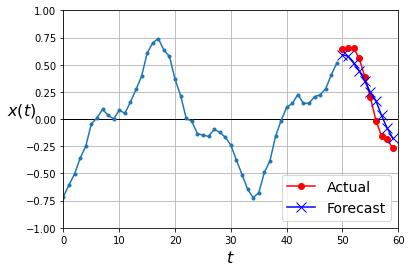

In [37]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## WaveNet

WaveNet was introduced by Google's DeepMind researchers. The stacked 1D convolutional layers together with varius dilation rates. Meaning only a few neurons were connected to the next layer.

The first layer starts of with 2 connection to the time steps, while the next will have 4, the next will have 8 connection to the layer before.

Similiar to how convolutional layers detect smaller patterns low level and then larger patterns as data gets passed through the network, stacking 1D convolutional layers allows us to detect long term patterns. This can allow us to work with extremely long sequences.

